In [1]:
%load_ext lab_black

In [2]:
import os
from typing import List, Optional
os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from icecream import ic

import matplotlib_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable


matplotlib_functions.setMatplotlibParam()
plt.viridis()
import joblib
import pickle
from include.generators import Generator
from saver import Saver
from include.callbacks import get_modelcheckpoint, ExtraValidation

import model_eval
from Data import Data_train, Data_eval
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger
import models.reg as rm

2023-11-27 17:37:15.076711: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 17:37:15.076751: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 17:37:15.076780: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 17:37:15.083670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: ERROR Unable to patch Tensorflow/Ke

<Figure size 1920x1440 with 0 Axes>

In [3]:
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [4]:
data = Data_train(path_train_nc, path_valid_nc, path_extra_valid_nc)
data.prepare_input("xco2", "no2")
data.prepare_output_inversion()

2023-11-27 17:37:23.371902: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14624 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:65:00.0, compute capability: 7.5
2023-11-27 17:37:25.559144: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


data.x.train.shape (25152, 64, 64, 2)


In [5]:
num_examples = 5
example_indices = np.random.choice(data.x.valid.shape[0], num_examples, replace=False)

ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1544
ic| np.min(data.x.valid[idx, :, :, 0]): -4.227347
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1496
ic| np.min(data.x.valid[idx, :, :, 0]): -4.227347
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 587
ic| np.min(data.x.valid[idx, :, :, 0]): -4.227347
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 1799
ic| np.min(data.x.valid[idx, :, :, 0]): -4.227347
ic| np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])): 684
ic| np.min(data.x.valid[idx, :, :, 0]): -4.227347


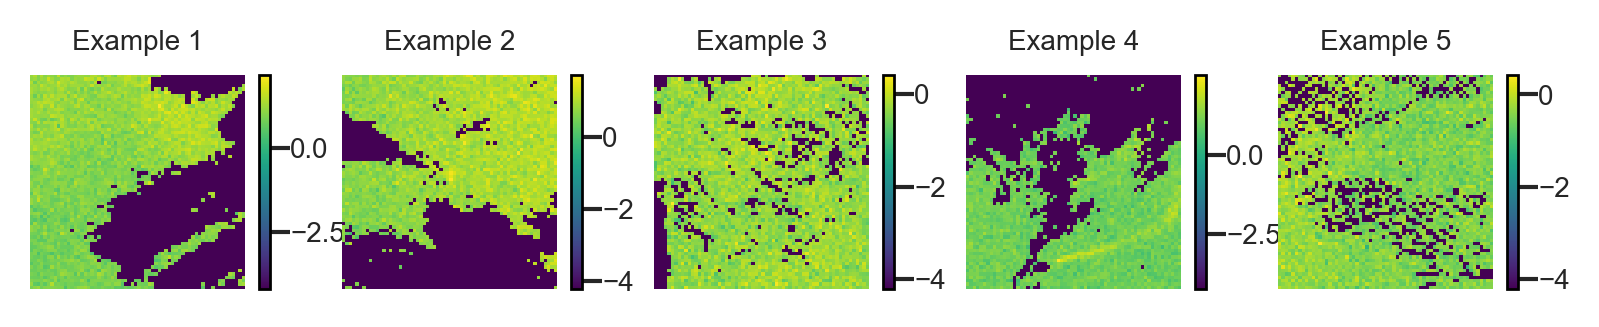

In [11]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(data.x.valid[idx, :, :, 0], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(data.x.valid[idx, :, :, 0] == np.min(data.x.valid[:, :, :, 0])))
    plt.colorbar(im, cax=cax)
    ic(np.min(data.x.valid[idx, :, :, 0]))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 827
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 601
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 115
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 732
ic| np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])): 110


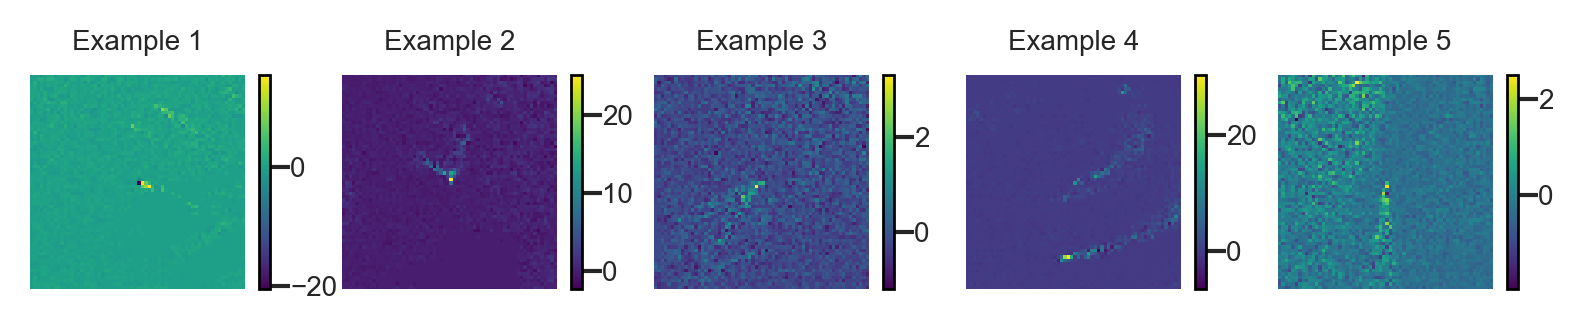

ic| np.median(data.x.valid[:, :, :, 1]): -0.1946075


-0.1946075

In [10]:
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(data.x.valid[idx, :, :, 1], cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    ic(np.sum(data.x.valid[idx, :, :, 1] == np.median(data.x.valid[:, :, :, 1])))
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
ic(np.median(data.x.valid[:, :, :, 1]))

In [14]:
mmap = np.load(data.x.path_clouds_array, mmap_mode="r")
clouds_valid = np.array(mmap[: data.x.ds_valid.N_img])


ic| np.sum(sel_clct_001[idx].squeeze() == 0): 1544
ic| np.sum(sel_clct_001[idx].squeeze() == 0): 1496
ic| np.sum(sel_clct_001[idx].squeeze() == 0): 587
ic| np.sum(sel_clct_001[idx].squeeze() == 0): 1799
ic| np.sum(sel_clct_001[idx].squeeze() == 0): 684


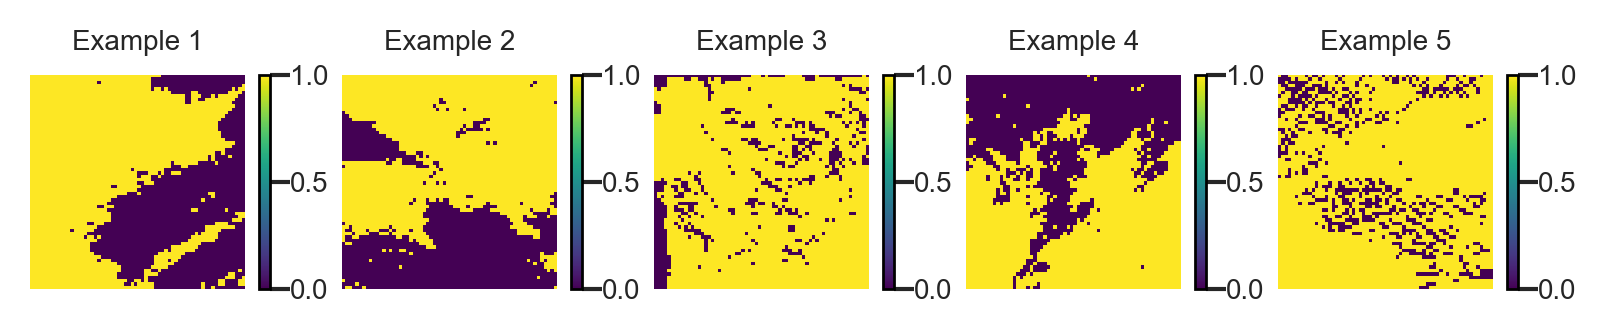

In [19]:
sel_clct_001 = (clouds_valid < 0.01).astype(int)
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(sel_clct_001[idx].squeeze(), cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")
    ic(np.sum(sel_clct_001[idx].squeeze() == 0))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ic| np.sum(sel_clct_03[idx].squeeze() == 0): 827
ic| np.sum(sel_clct_03[idx].squeeze() == 0): 601
ic| np.sum(sel_clct_03[idx].squeeze() == 0): 115
ic| np.sum(sel_clct_03[idx].squeeze() == 0): 732
ic| np.sum(sel_clct_03[idx].squeeze() == 0): 110


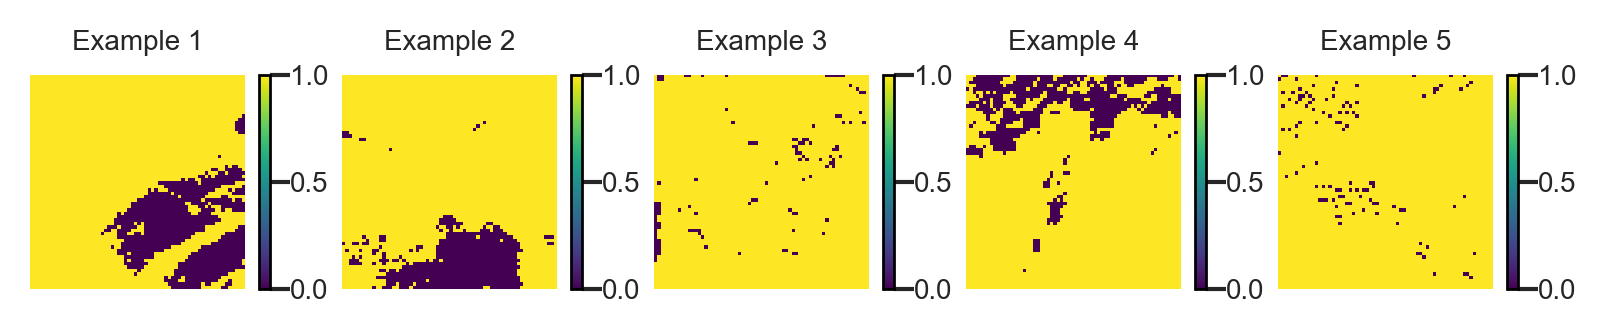

In [20]:
sel_clct_03 = (clouds_valid < 0.3).astype(int)
for i, idx in enumerate(example_indices):
    ax = plt.subplot(1, num_examples, i + 1)
    im = ax.imshow(sel_clct_03[idx].squeeze(), cmap="viridis")
    plt.title(f"Example {i+1}")
    plt.axis("off")
    ic(np.sum(sel_clct_03[idx].squeeze() == 0))

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

In [35]:
modified_channels = []

for idx, chan_name in enumerate(data.x.list_chans):
    channel_data = data.x.valid[:, :, :, idx].numpy()  # Convert to NumPy array

    if chan_name in ["xco2", "no2"]:
        threshold = 0.01 if chan_name == "xco2" else 0.3
        bin_threshold = (clouds_valid < threshold).astype(int)

        # Apply the clouding effect using NumPy
        channel_data[bin_threshold == 0] = np.nan
        channel_data = np.nan_to_num(channel_data, nan=np.nanmin(channel_data))

    # Add the modified channel data to the list
    modified_channels.append(channel_data)

# Stack the modified channels and convert back to a TensorFlow tensor
data.x.valid = tf.stack([tf.convert_to_tensor(channel) for channel in modified_channels], axis=-1)


2023-11-27 17:01:27.440577: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 3 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 1 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

In [30]:

for idx, chan_name in enumerate(data.x.list_chans):
    if chan_name in ["xco2", "no2"]:
        threshold = 0.01 if chan_name == "xco2" else 0.3
        bin_threshold = (clouds_valid < threshold).astype(int)

        # Convert the TensorFlow tensor to a NumPy array for modification
        channel_data_np = data.x.valid[:, :, :, idx].numpy()

        # Apply the clouding effect using NumPy
        channel_data_np[bin_threshold == 0] = np.nan
        channel_data_np = np.nan_to_num(channel_data_np, nan=np.nanmin(channel_data_np))

        # Convert back to a TensorFlow tensor and assign it back
        data.x.valid[:, :, :, idx] = tf.convert_to_tensor(channel_data_np)

# Ensure data.x.valid is a TensorFlow tensor
data.x.valid = tf.convert_to_tensor(data.x.valid)

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [34]:
type(data.x.valid)

tensorflow.python.framework.ops.EagerTensor

In [22]:
channel_data.shape

TensorShape([4608, 64, 64])

In [14]:
path_clouds_array = "/libre/dumontj/coco2/dl-input/clouds/extracted_clouds.npy"
mmap = np.load(path_clouds_array, mmap_mode="r")


In [21]:
ds_valid = xr.open_dataset(path_valid_nc)
list_chans = "xco2"
data = np.expand_dims(ds_valid.xco2.values, -1)
clouds = np.array(mmap[: ds_valid.N_img])

In [25]:
chan_name = "xco2"
idx = 0

In [26]:
threshold = 0.01 if chan_name == "xco2" else 0.3
bin_threshold = (clouds < threshold).astype(int)
channel_data = data[:, :, :, idx]
channel_data[bin_threshold == 0] = np.nan
data[:, :, :, idx] = np.nan_to_num(
    channel_data, nan=np.nanmin(channel_data)
)

In [7]:
def apply_clouds_to_data(data, list_chans, clouds):
    for idx, chan_name in enumerate(list_chans):
        if chan_name in ["xco2", "no2"]:
            threshold = 0.01 if chan_name == "xco2" else 0.3
            bin_threshold = (clouds < threshold).astype(int)
            channel_data = data[:, :, :, idx]
            ic(channel_data)
            channel_data[bin_threshold == 0] = np.nan
            data[:, :, :, idx] = np.nan_to_num(
                channel_data, nan=np.nanmin(channel_data)
            )
    return data